In [11]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import re

In [12]:
df = pd.read_excel("../data/food_data.xlsx")

In [13]:
df.head()

,description,sub_category,main_category,category,energy (kJ),carbohydrate_G,vitamin_A_UG,calcium_MG,potassium_MG,zinc_MG,...,folate_total_UG,vitamin B_12_UG,thiamin_MG,riboflavin_MG,cholesterol_MG,Niacin_MG,vitamin_B_6_MG,selenium_UG,vitamin D _UG,choline_total_MG
0,"Abiyuch, raw",Fruit,Veg,Fruits and Fruit Juices,290.0,17.60,5.0,8.0,304.0,0.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Acerola juice, raw",Juice,Veg,Fruits and Fruit Juices,96.0,4.80,25.0,10.0,97.0,0.10,...,14.0,0.0,0.020,0.060,0.0,0.400,0.004,0.1,NaN,NaN
2,"Acerola, (west indian cherry), raw",Fruit,Veg,Fruits and Fruit Juices,134.0,7.69,38.0,12.0,146.0,0.10,...,14.0,0.0,0.020,0.060,0.0,0.400,0.009,0.6,NaN,NaN
3,"Alfalfa seeds, sprouted, raw",Vegetable,Veg,Vegetables and Vegetable Products,96.0,2.10,8.0,32.0,79.0,0.92,...,36.0,0.0,0.076,0.126,0.0,0.481,0.034,0.6,0.0,14.4
4,"Amaranth leaves, raw",Vegetable,Veg,Vegetables and Vegetable Products,97.0,4.02,146.0,215.0,611.0,0.90,...,85.0,0.0,0.027,0.158,0.0,0.658,0.192,0.9,0.0,NaN


In [14]:
df.main_category.unique()

array(['Veg', 'Non-veg', 'Non Alcoholic'], dtype=object)

In [15]:
df.rename(columns={'vitamin_K_ UG': 'vitamin_K_UG', 'vitamin D _UG' : 'vitamin_D_UG', 'vitamin B_12_UG' : 'vitamin_B_12_UG'}, inplace=True)

In [16]:
df.shape

(1166, 36)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   description                          1166 non-null   object 
 1   sub_category                         1166 non-null   object 
 2   main_category                        1166 non-null   object 
 3   category                             1166 non-null   object 
 4   energy (kJ)                          1048 non-null   float64
 5   carbohydrate_G                       1162 non-null   float64
 6   vitamin_A_UG                         994 non-null    float64
 7   calcium_MG                           1164 non-null   float64
 8   potassium_MG                         1150 non-null   float64
 9   zinc_MG                              1132 non-null   float64
 10  water_G                              1164 non-null   float64
 11  total_lipid_fat_G             

In [18]:
df.isnull().sum()

description                              0
sub_category                             0
main_category                            0
category                                 0
energy (kJ)                            118
carbohydrate_G                           4
vitamin_A_UG                           172
calcium_MG                               2
potassium_MG                            16
zinc_MG                                 34
water_G                                  2
total_lipid_fat_G                        0
protein_G                                2
fatty_acids_total_saturated_G          162
vitamin_C_MG                           125
fiber_total_dietary_G                  140
iron_MG                                  4
magnesium_MG                            26
phosphorus_MG                           15
sodium_MG                                6
copper_MG                               37
total_sugars_G                         463
fatty_acids_total_monounsaturated_G    176
vitamin_K_U

In [19]:
df.columns

Index(['description', 'sub_category', 'main_category', 'category',
       'energy (kJ)', 'carbohydrate_G', 'vitamin_A_UG', 'calcium_MG',
       'potassium_MG', 'zinc_MG', 'water_G', 'total_lipid_fat_G', 'protein_G',
       'fatty_acids_total_saturated_G', 'vitamin_C_MG',
       'fiber_total_dietary_G', 'iron_MG', 'magnesium_MG', 'phosphorus_MG',
       'sodium_MG', 'copper_MG', 'total_sugars_G',
       'fatty_acids_total_monounsaturated_G', 'vitamin_K_UG', 'vitamin_E_MG',
       'fatty_acids_total_polyunsaturated_G', 'folate_total_UG',
       'vitamin_B_12_UG', 'thiamin_MG', 'riboflavin_MG', 'cholesterol_MG',
       'Niacin_MG', 'vitamin_B_6_MG', 'selenium_UG', 'vitamin_D_UG',
       'choline_total_MG'],
      dtype='object')

### Preprocessing

In [20]:
# Cleaning
df['description'] = df['description'].apply(lambda x: x[:-5] if x.endswith(", raw") else x)
df['main_category'] = df['main_category'].apply(lambda x: "Veg" if x == "Non Alcoholic" else x)
df['description'] = df['description'].apply(lambda x: re.sub(r"^Game meat,\s*", "", x).capitalize())

In [21]:
df.fillna(0, inplace = True)

In [22]:

in_mg = ['calcium_MG', 'potassium_MG', 'zinc_MG', 'vitamin_C_MG', 'iron_MG', 'magnesium_MG', 'phosphorus_MG',
          'sodium_MG', 'copper_MG', 'vitamin_E_MG', 'thiamin_MG', 'riboflavin_MG', 'cholesterol_MG', 'Niacin_MG', 
          'vitamin_B_6_MG', 'choline_total_MG']

in_grams = ['carbohydrate_G', 'water_G', 'total_lipid_fat_G', 'protein_G', 'fatty_acids_total_saturated_G', 
            'fiber_total_dietary_G','total_sugars_G', 'fatty_acids_total_monounsaturated_G', 
            'fatty_acids_total_polyunsaturated_G' ]

in_ug = ['vitamin_A_UG', 'vitamin_K_UG', 'folate_total_UG', 'vitamin_B_12_UG', 'selenium_UG', 'vitamin_D_UG' ]

others = ['description', 'sub_category', 'main_category', 'category', 'energy (kJ)']

# Convert grams to milligrams (g → mg)
df[in_grams] = df[in_grams] * 1000

# Convert micrograms to milligrams (µg → mg)
df[in_ug] = df[in_ug] / 1000




In [23]:

df.columns = df.columns.str.replace(r'_(UG|MG|G)$', '', regex=True)

In [24]:
df.columns

Index(['description', 'sub_category', 'main_category', 'category',
       'energy (kJ)', 'carbohydrate', 'vitamin_A', 'calcium', 'potassium',
       'zinc', 'water', 'total_lipid_fat', 'protein',
       'fatty_acids_total_saturated', 'vitamin_C', 'fiber_total_dietary',
       'iron', 'magnesium', 'phosphorus', 'sodium', 'copper', 'total_sugars',
       'fatty_acids_total_monounsaturated', 'vitamin_K', 'vitamin_E',
       'fatty_acids_total_polyunsaturated', 'folate_total', 'vitamin_B_12',
       'thiamin', 'riboflavin', 'cholesterol', 'Niacin', 'vitamin_B_6',
       'selenium', 'vitamin_D', 'choline_total'],
      dtype='object')

In [25]:
df['iron'].max()

41.9

In [26]:
# Select relevant columns (nutrients for modeling)
nutrients = ['calcium', 'potassium', 'zinc', 'vitamin_C', 'iron', 'magnesium', 'phosphorus','sodium', 'copper',
              'vitamin_E', 'thiamin', 'riboflavin', 'cholesterol', 'Niacin', 'vitamin_B_6', 'choline_total',
              'vitamin_A', 'vitamin_K', 'folate_total', 'vitamin_B_12', 'selenium', 'vitamin_D' ]

# Normalize the nutrient values for ML
scaler = MinMaxScaler()
df[nutrients] = scaler.fit_transform(df[nutrients])

# Save the processed data
df.to_csv("processed_food_data.csv", index=False)
print("✅ Data preprocessing complete! File saved as 'processed_food_data.csv'.")


✅ Data preprocessing complete! File saved as 'processed_food_data.csv'.


# Filtering data based on one deficiency.

In [27]:
# Load processed dataset
df = pd.read_csv("processed_food_data.csv")

# Define features (nutrient values)
nutrients = ['calcium', 'potassium', 'zinc', 'vitamin_C', 'iron', 'magnesium', 'phosphorus','sodium', 'copper',
              'vitamin_E', 'thiamin', 'riboflavin', 'cholesterol', 'Niacin', 'vitamin_B_6', 'choline_total',
              'vitamin_A', 'vitamin_K', 'folate_total', 'vitamin_B_12', 'selenium', 'vitamin_D' ]
X = df[nutrients]

# Train a KNN model
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X)

def recommend_food(deficiency):
    """Recommend food items based on a user's nutrient deficiency."""
    if deficiency not in nutrients:
        return "Invalid deficiency. Choose from: " + ", ".join(nutrients)

    # Create a query vector: 1 for the deficient nutrient, 0 for others
    deficiency_idx = nutrients.index(deficiency)
    sample = np.zeros(len(nutrients))
    sample[deficiency_idx] = 1  # Targeting the deficient nutrient

    # Find similar foods
    distances, indices = knn.kneighbors([sample])
    recommendations = df.iloc[indices[0]][['description', deficiency]]

    return recommendations.to_dict(orient="records")

# Test the model
print("✅ Model trained. Testing recommendations...\n")

print("🥗 Vitamin C Deficiency:")
print(recommend_food("vitamin_C"))

print("\n🥩 Iron Deficiency:")
print(recommend_food("iron"))


✅ Model trained. Testing recommendations...

🥗 Vitamin C Deficiency:


/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


[{'description': 'Acerola, (west indian cherry)', 'vitamin_C': 1.0}, {'description': 'Acerola juice', 'vitamin_C': 0.9523809523809524}, {'description': 'Beverages, tea, green, instant, decaffeinated, lemon, unsweetened, fortified with vitamin c', 'vitamin_C': 0.7976190476190477}, {'description': 'Guavas, common', 'vitamin_C': 0.1357142857142857}, {'description': 'Peppers, hot chili, green', 'vitamin_C': 0.144047619047619}, {'description': 'Peppers, sweet, yellow', 'vitamin_C': 0.1095238095238095}, {'description': 'Mango, ataulfo, peeled', 'vitamin_C': 0.1}, {'description': 'Currants, european black', 'vitamin_C': 0.1077380952380952}, {'description': 'Kiwifruit, zespri sungold', 'vitamin_C': 0.0958333333333333}, {'description': 'Peppers, bell, orange', 'vitamin_C': 0.094047619047619}]

🥩 Iron Deficiency:
[{'description': 'Lamb, variety meats and by-products, spleen', 'iron': 1.0}, {'description': 'Pork, fresh, variety meats and by-products, spleen', 'iron': 0.5322195704057279}, {'descri

/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


# Filtering data based on multiple deficiencies

In [28]:

# Load processed dataset
df = pd.read_csv("processed_food_data.csv")

# Define features (nutrient values)
nutrients = ['calcium', 'potassium', 'zinc', 'vitamin_C', 'iron', 'magnesium', 'phosphorus', 'sodium', 'copper',
             'vitamin_E', 'thiamin', 'riboflavin', 'cholesterol', 'Niacin', 'vitamin_B_6', 'choline_total',
             'vitamin_A', 'vitamin_K', 'folate_total', 'vitamin_B_12', 'selenium', 'vitamin_D']
X = df[nutrients]

# Train a KNN model
knn = NearestNeighbors(n_neighbors=40, metric='euclidean')
knn.fit(X)

def recommend_food(deficiencies):
    """Recommend food items based on a user's nutrient deficiencies."""
    if not isinstance(deficiencies, list):
        return "Invalid input. Provide a list of deficiencies."
    
    invalid_nutrients = [d for d in deficiencies if d not in nutrients]
    if invalid_nutrients:
        return f"Invalid deficiencies: {', '.join(invalid_nutrients)}. Choose from: {', '.join(nutrients)}"

    # Create a query vector: 1 for deficient nutrients, 0 for others
    sample = np.zeros(len(nutrients))
    for deficiency in deficiencies:
        sample[nutrients.index(deficiency)] = 1  # Targeting deficient nutrients

    # Find similar foods
    distances, indices = knn.kneighbors([sample])
    recommendations = df.iloc[indices[0]][['description'] + deficiencies]

    return "\n".join([str(item) for item in recommendations.to_dict(orient="records")])

# Test the model
print("✅ Model trained. Testing recommendations...\n")

print("🥗 Vitamin C and Iron Deficiency:")
print(recommend_food(["vitamin_C", "iron"]))

print("\n🥩 Calcium and Magnesium Deficiency:")
print(recommend_food(["calcium", "magnesium"]))


✅ Model trained. Testing recommendations...

🥗 Vitamin C and Iron Deficiency:


/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


{'description': 'Acerola juice', 'vitamin_C': 0.9523809523809524, 'iron': 0.0119331742243436}
{'description': 'Acerola, (west indian cherry)', 'vitamin_C': 1.0, 'iron': 0.0047732696897374}
{'description': 'Beverages, tea, green, instant, decaffeinated, lemon, unsweetened, fortified with vitamin c', 'vitamin_C': 0.7976190476190477, 'iron': 0.0050119331742243}
{'description': 'Lamb, variety meats and by-products, spleen', 'vitamin_C': 0.0136904761904761, 'iron': 1.0}
{'description': 'Pork, fresh, variety meats and by-products, spleen', 'vitamin_C': 0.0169642857142857, 'iron': 0.5322195704057279}
{'description': 'Pork, fresh, variety meats and by-products, lungs', 'vitamin_C': 0.0073214285714285, 'iron': 0.4510739856801908}
{'description': 'Mushrooms, morel', 'vitamin_C': 0.0, 'iron': 0.2911694510739857}
{'description': 'Lemon grass (citronella)', 'vitamin_C': 0.001547619047619, 'iron': 0.1949880668257756}
{'description': 'Peppers, hot chili, green', 'vitamin_C': 0.144047619047619, 'iron'

/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


###  Filtering food based on category veg/Non - veg

In [29]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# Assuming df is already loaded with the dataset
df = pd.read_csv("processed_food_data.csv")

# Define the nutrients list within the function
def recommend_food(deficiencies, category=None):
    """Recommend food items based on a user's nutrient deficiencies, with optional category filtering."""
    
    # Define nutrients inside the function
    nutrients = ['calcium', 'potassium', 'zinc', 'vitamin_C', 'iron', 'magnesium', 'phosphorus', 'sodium', 'copper',
                 'vitamin_E', 'thiamin', 'riboflavin', 'cholesterol', 'Niacin', 'vitamin_B_6', 'choline_total',
                 'vitamin_A', 'vitamin_K', 'folate_total', 'vitamin_B_12', 'selenium', 'vitamin_D']
    
    if not isinstance(deficiencies, list):
        return "Invalid input. Provide a list of deficiencies."
    
    # Check for invalid deficiencies
    invalid_nutrients = [d for d in deficiencies if d not in nutrients]
    if invalid_nutrients:
        return f"Invalid deficiencies: {', '.join(invalid_nutrients)}. Choose from: {', '.join(nutrients)}"

    # Filter by category (if specified)
    if category == 'Veg':
        # Filter the dataframe based on the main category (e.g., 'Veg')
        df_filtered = df[df['main_category'] == category]
        if df_filtered.empty:
            return f"No data found for the category: {category}."
    else:
        df_filtered = df  # If no category is selected, use the whole dataframe

    # Create a query vector: 1 for deficient nutrients, 0 for others
    sample = np.zeros(len(nutrients))
    for deficiency in deficiencies:
        sample[nutrients.index(deficiency)] = 1  # Targeting deficient nutrients

    # Train the KNN model on the filtered data (to ensure it's category-specific)
    X_filtered = df_filtered[nutrients]
    knn = NearestNeighbors(n_neighbors=40, metric='euclidean')
    knn.fit(X_filtered)

    # Find similar foods
    distances, indices = knn.kneighbors([sample])
    recommendations = df_filtered.iloc[indices[0]][['description'] + deficiencies]

    # Format recommendations as a list of strings
    recommendation_list = [f"\nRecommendations for {' and '.join(deficiencies)} Deficiency:"]
    for i, row in recommendations.iterrows():
        recommendation_list.append(f"Food: {row['description']}, {', '.join([f'{d.capitalize()}: {row[d]} mg' for d in deficiencies])}")

    return "\n".join(recommendation_list)

# Test the model with multiple deficiencies and category filtering
print("✅ Model trained. Testing recommendations...\n")

print("🥗 Vitamin C and Iron Deficiency (Veg Only):")
print(recommend_food(["vitamin_C", "iron"], category="Non-veg"))

print("\n🥩 Calcium and Magnesium Deficiency (Veg Only):")
print(recommend_food(["calcium", "magnesium"], category="Non-veg"))


✅ Model trained. Testing recommendations...

🥗 Vitamin C and Iron Deficiency (Veg Only):

Recommendations for vitamin_C and iron Deficiency:
Food: Acerola juice, Vitamin_c: 0.9523809523809524 mg, Iron: 0.0119331742243436 mg
Food: Acerola, (west indian cherry), Vitamin_c: 1.0 mg, Iron: 0.0047732696897374 mg
Food: Beverages, tea, green, instant, decaffeinated, lemon, unsweetened, fortified with vitamin c, Vitamin_c: 0.7976190476190477 mg, Iron: 0.0050119331742243 mg
Food: Lamb, variety meats and by-products, spleen, Vitamin_c: 0.0136904761904761 mg, Iron: 1.0 mg
Food: Pork, fresh, variety meats and by-products, spleen, Vitamin_c: 0.0169642857142857 mg, Iron: 0.5322195704057279 mg
Food: Pork, fresh, variety meats and by-products, lungs, Vitamin_c: 0.0073214285714285 mg, Iron: 0.4510739856801908 mg
Food: Mushrooms, morel, Vitamin_c: 0.0 mg, Iron: 0.2911694510739857 mg
Food: Lemon grass (citronella), Vitamin_c: 0.001547619047619 mg, Iron: 0.1949880668257756 mg
Food: Peppers, hot chili, gree

/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(



Recommendations for calcium and magnesium Deficiency:
Food: Tofu, raw, firm, prepared with calcium sulfate, Calcium: 0.4553333333333333 mg, Magnesium: 0.116 mg
Food: Lambsquarters, raw (northern plains indians), Calcium: 0.244 mg, Magnesium: 0.326 mg
Food: Nuts, almonds, whole, Calcium: 0.1693333333333333 mg, Magnesium: 0.516 mg
Food: Chia seeds, dry, Calcium: 0.3966666666666666 mg, Magnesium: 0.652 mg
Food: Fireweed, leaves, Calcium: 0.286 mg, Magnesium: 0.312 mg
Food: Cheese, mexican, blend, reduced fat, Calcium: 0.7666666666666666 mg, Magnesium: 0.07 mg
Food: Cheese, swiss, low fat, Calcium: 0.6406666666666666 mg, Magnesium: 0.072 mg
Food: Cheese, swiss, low sodium, Calcium: 0.6406666666666666 mg, Magnesium: 0.072 mg
Food: Cheese, gruyere, Calcium: 0.6733333333333333 mg, Magnesium: 0.072 mg
Food: Cheese, swiss, Calcium: 0.5933333333333333 mg, Magnesium: 0.0668 mg
Food: Cheese, swiss, Calcium: 0.5933333333333333 mg, Magnesium: 0.066 mg
Food: Cheese, american, nonfat or fat free, Cal

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def evaluate_knn():
    kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust clusters based on dataset
    cluster_labels = kmeans.fit_predict(X)  # Assign each food item to a cluster

    score = silhouette_score(X, cluster_labels)
    print(f"Silhouette Score for KNN-based Food Clustering: {score:.2f}")

evaluate_knn()


/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for KNN-based Food Clustering: 0.50


/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

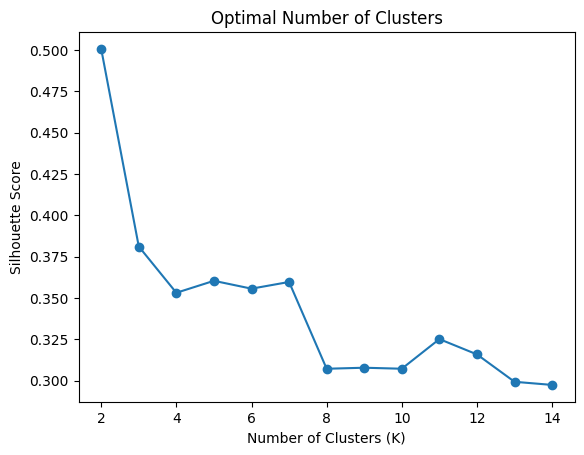

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
cluster_range = range(2, 15)  # Test cluster sizes from 2 to 15

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    scores.append(score)

# Plot silhouette scores
plt.plot(cluster_range, scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.show()

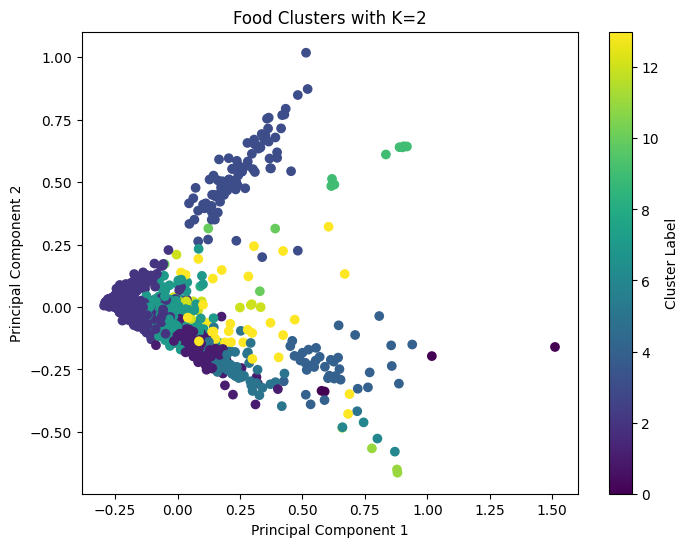

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.title(f"Food Clusters with K={2}")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


KNN Neighborhood Visualization

/home/minhas/cgn-dp-24-1/culinary_compass/.venv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


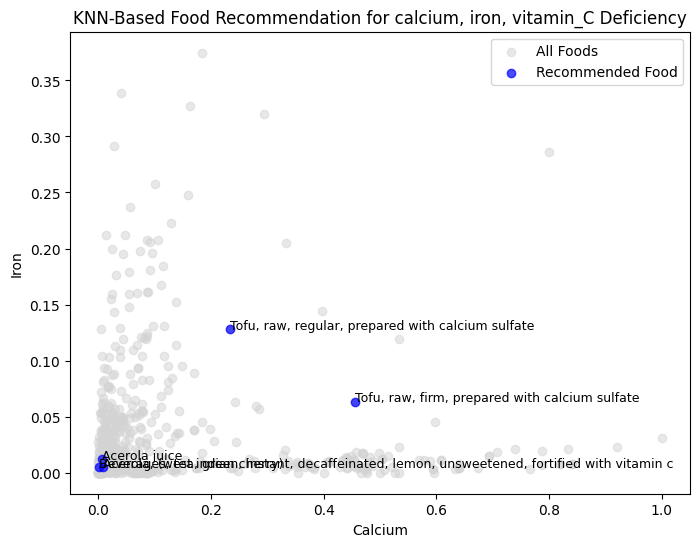


🔍 Top 5 Recommended Foods for calcium, iron, vitamin_C Deficiency:
2. Acerola juice - Calcium: 0.0066666666666666 mg, Iron: 0.0119331742243436 mg, Vitamin_c: 0.9523809523809524 mg
3. Acerola, (west indian cherry) - Calcium: 0.008 mg, Iron: 0.0047732696897374 mg, Vitamin_c: 1.0 mg
1153. Beverages, tea, green, instant, decaffeinated, lemon, unsweetened, fortified with vitamin c - Calcium: 0.0013333333333333 mg, Iron: 0.0050119331742243 mg, Vitamin_c: 0.7976190476190477 mg
829. Tofu, raw, firm, prepared with calcium sulfate - Calcium: 0.4553333333333333 mg, Iron: 0.0634844868735083 mg, Vitamin_c: 0.0001190476190476 mg
830. Tofu, raw, regular, prepared with calcium sulfate - Calcium: 0.2333333333333333 mg, Iron: 0.1279236276849642 mg, Vitamin_c: 5.952380952380953e-05 mg


In [39]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("processed_food_data.csv")

def plot_knn_recommendation(deficiencies, category=None, k=5):
    """Plot the KNN recommendation process based on deficiencies."""
    
    # Define nutrients
    nutrients = ['calcium', 'potassium', 'zinc', 'vitamin_C', 'iron', 'magnesium', 'phosphorus', 'sodium', 'copper',
                 'vitamin_E', 'thiamin', 'riboflavin', 'cholesterol', 'Niacin', 'vitamin_B_6', 'choline_total',
                 'vitamin_A', 'vitamin_K', 'folate_total', 'vitamin_B_12', 'selenium', 'vitamin_D']
    
    # Validate deficiencies
    for deficiency in deficiencies:
        if deficiency not in nutrients:
            raise ValueError(f"Invalid deficiency: {deficiency}. Choose from: {', '.join(nutrients)}")

    # Filter category if needed
    if category:
        df_filtered = df[df['main_category'] == category]
    else:
        df_filtered = df  # Use full dataset if no category is specified

    # Create a deficiency-based query vector
    sample = np.zeros(len(nutrients))
    for deficiency in deficiencies:
        sample[nutrients.index(deficiency)] = 1  # Mark deficiencies

    # Train KNN model
    X_filtered = df_filtered[nutrients]
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(X_filtered)

    # Find nearest food recommendations
    distances, indices = knn.kneighbors([sample])
    recommended_foods = df_filtered.iloc[indices[0]]

    # Choose two nutrients for plotting (first two deficiencies)
    x_axis = deficiencies[0]
    y_axis = deficiencies[1] if len(deficiencies) > 1 else 'iron'  # Default to Iron if only one deficiency is given

    # Plot all foods in gray
    plt.figure(figsize=(8, 6))
    plt.scatter(df_filtered[x_axis], df_filtered[y_axis], color='lightgray', label='All Foods', alpha=0.5)

    # Highlight recommended foods in blue
    for i, idx in enumerate(indices[0]):
        plt.scatter(df_filtered.iloc[idx][x_axis], df_filtered.iloc[idx][y_axis], color='blue', label='Recommended Food' if i == 0 else "", alpha=0.7)
        plt.annotate(df_filtered.iloc[idx]['description'], (df_filtered.iloc[idx][x_axis], df_filtered.iloc[idx][y_axis]), fontsize=9)

    # Labels and title
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f"KNN-Based Food Recommendation for {', '.join(deficiencies)} Deficiency")
    plt.legend()
    plt.show()

    # Print recommendations
    print(f"\n🔍 Top {k} Recommended Foods for {', '.join(deficiencies)} Deficiency:")
    for i, row in recommended_foods.iterrows():
        print(f"{i+1}. {row['description']} - {', '.join([f'{d.capitalize()}: {row[d]} mg' for d in deficiencies])}")

# Example: Plot recommendations for Iron & Vitamin C deficiency (Veg)
plot_knn_recommendation(deficiencies=["calcium", "iron", "niacin"], category="Veg", k=5)
